# Tabluar Data Science Ex 2

## 1. Error Analysis Conclusions & work plan

First, we will import all the necessary libraries required for our task:

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import scipy.stats as stats

Next, we will define an error analysis function to evaluate and analyze the improvements made to the model:

In [229]:
def error_analysis(y_test, y_pred):

    fig = plt.figure(figsize=(20, 12))
    grid = fig.add_gridspec(2, 3, height_ratios=[3, 1])

    ax1 = fig.add_subplot(grid[0, 0])
    ax1.scatter(y_test, y_pred, alpha=0.6)
    ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    ax1.set_title('Actual vs Predicted Popularity', fontsize=14)
    ax1.set_xlabel('Actual Popularity', fontsize=12)
    ax1.set_ylabel('Predicted Popularity', fontsize=12)

    residuals = y_test - y_pred
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.hist(residuals, bins=30, color='skyblue', edgecolor='black')
    ax2.set_title('Histogram of Residuals', fontsize=14)
    ax2.set_xlabel('Residuals', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.grid(alpha=0.4, linestyle='--')

    ax3 = fig.add_subplot(grid[0, 2])
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.get_lines()[1].set_color('red')
    ax3.set_title('QQ Plot of Residuals', fontsize=14)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)

    table = fig.add_subplot(grid[1, :])
    table.axis('off')
    metrics_data = [
        ["Metric", "Value"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.2f}"],
        ["R-squared (R²)", f"{r2:.2f}"],
        ["Mean Absolute Error (MAE)", f"{mae:.2f}"],
        ["Explained Variance Score (EVS)", f"{evs:.2f}"]
    ]

    table = table.table(
        cellText=metrics_data,
        colLabels=None,
        cellLoc='center',
        loc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.auto_set_column_width([0, 1])
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    plt.tight_layout(h_pad=2)
    plt.show()



Now, we will load the pipeline we constructed in the previous homework:

In [230]:
raw_data = pd.read_csv('data/music_genre.csv')

id_features = ['instance_id', 'artist_name', 'track_name']
raw_data = raw_data.drop(id_features, axis=1)

raw_data["tempo"] = pd.to_numeric(raw_data["tempo"], errors="coerce")

raw_data = raw_data.dropna()

X = raw_data.drop('popularity', axis=1)
y = raw_data['popularity']

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['float64', 'int64']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

model = XGBRegressor(n_estimators=100, learning_rate=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

And display the errors:

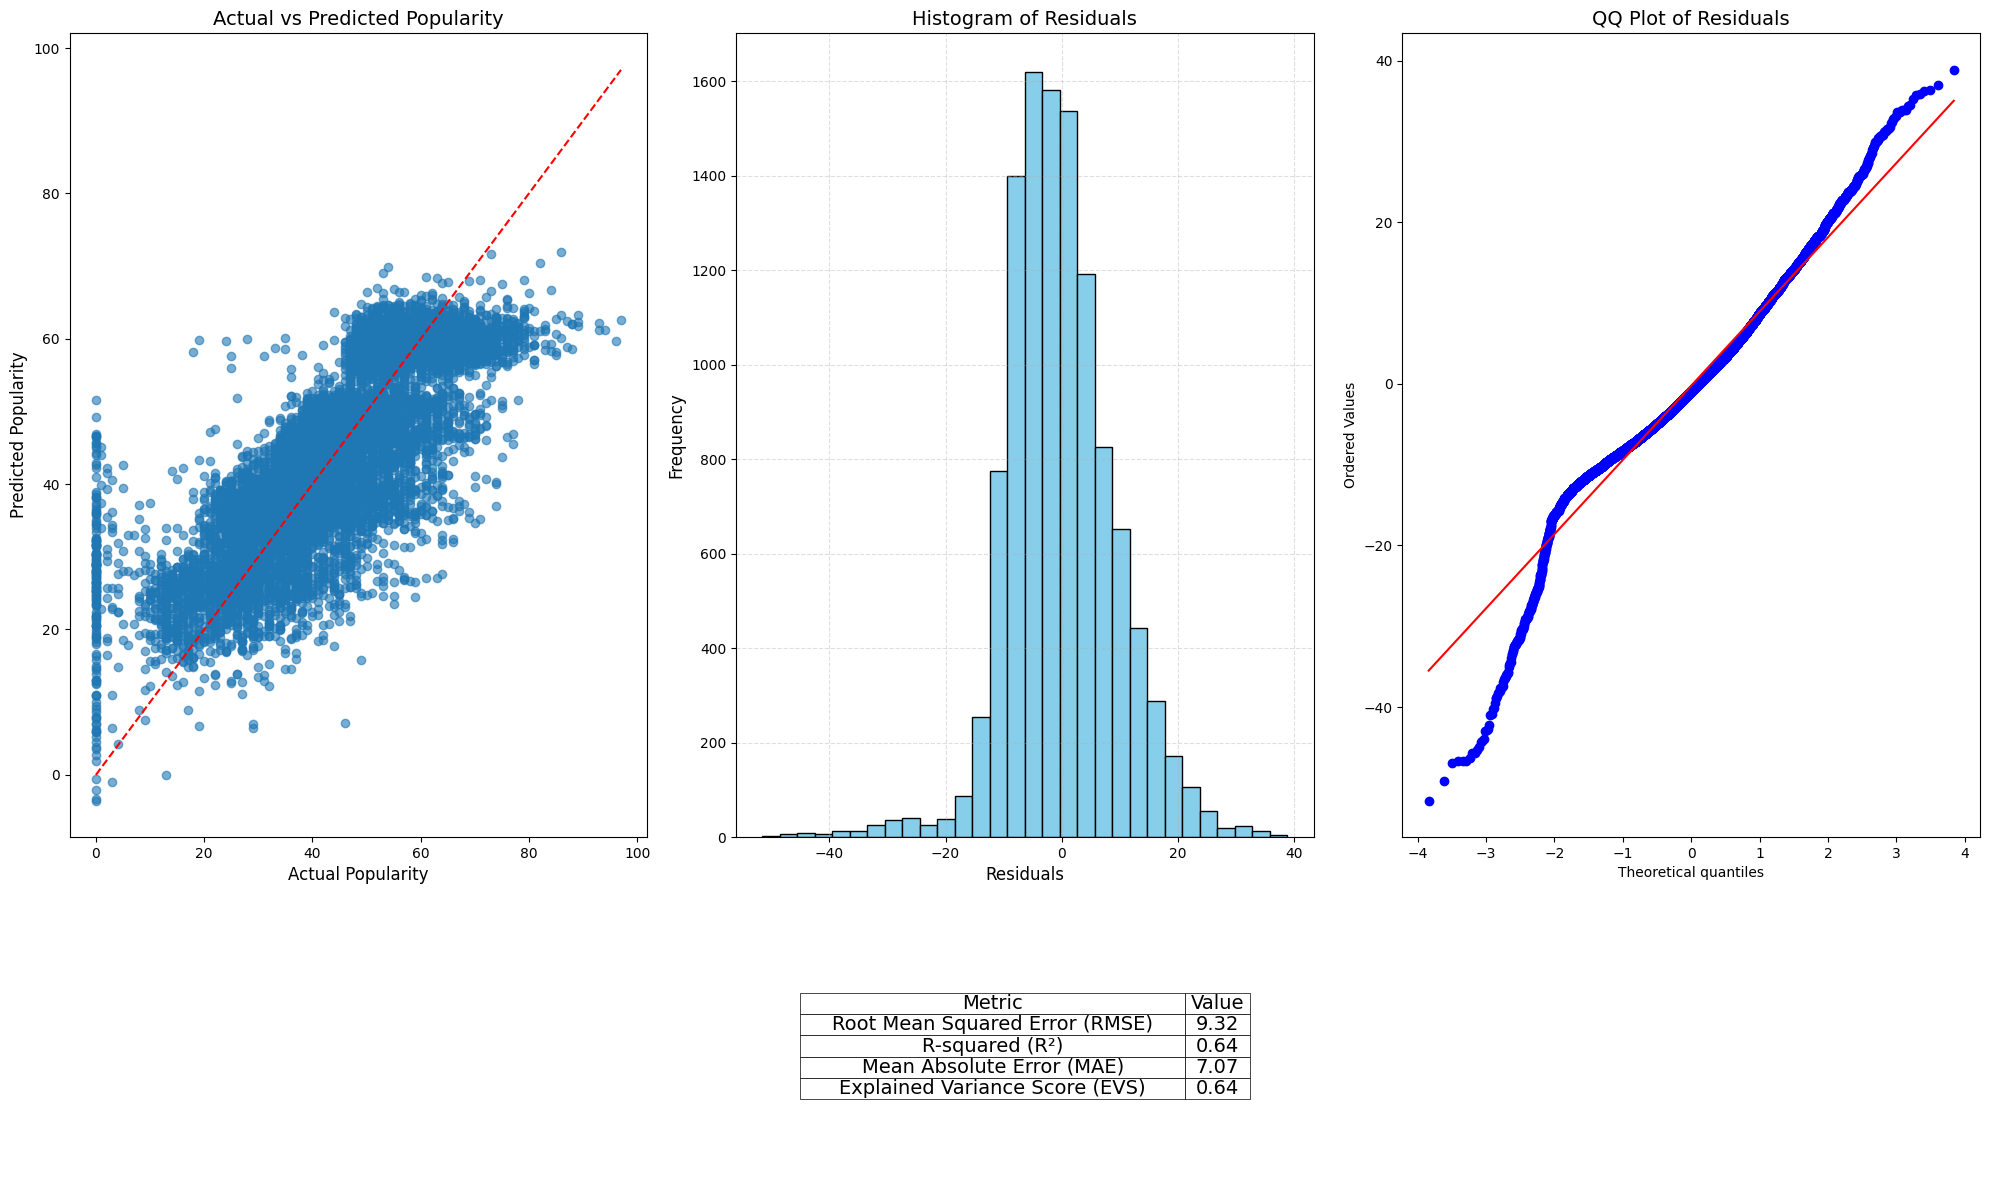

In [231]:
error_analysis(y_test, y_pred)
base_residuals = y_test - y_pred


All three plots shows significant errors at the extremes, with overestimations at low popularity and underestimations at high popularity, possibly due to unmodeled non-linear relationships or noise in the Data. Metrics like RMSE and R² show that while the model captures general trends, it leaves significant variance unexplained. These issues may be caused by limitations in the features used, target imbalance, or insufficient model complexity. To improve, I plan to engineer new features, remove outliers, and optimize hyperparameters.

##  2. Improving Model Performance

### missing data and outliers handling

First, we can see a big unexplaind cluster in the point of 0 popularity, so we will define a remove_outliers_from_zero_popularity function to eliminate extreme values from each numerical feature

In [232]:
def remove_outliers_from_zero_popularity(df, features, target='popularity'):

    zero_popularity_df = df[df[target] == 0].copy()
    non_zero_popularity_df = df[df[target] != 0].copy()
    
    for feature in features:
        if pd.api.types.is_numeric_dtype(zero_popularity_df[feature]):
            Q1 = zero_popularity_df[feature].quantile(0.25)
            Q3 = zero_popularity_df[feature].quantile(0.75)
            IQR = Q3 - Q1

            mask = (zero_popularity_df[feature] >= (Q1 - 1.5 * IQR)) & (zero_popularity_df[feature] <= (Q3 + 1.5 * IQR))
            zero_popularity_df = zero_popularity_df[mask]
    

    cleaned_df = pd.concat([zero_popularity_df, non_zero_popularity_df], axis=0).reset_index(drop=True)
    
    return cleaned_df

raw_data = remove_outliers_from_zero_popularity(raw_data, num_features)
raw_data = remove_outliers_from_zero_popularity(raw_data, num_features)



Additionally, we will implement missing data handling to our pipline

In [233]:
X = raw_data.drop('popularity', axis=1)
y = raw_data['popularity']

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['float64', 'int64']).columns

X_train, X_test, y_train, y_test_new = train_test_split(X, y, test_size=0.25, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

model = XGBRegressor(n_estimators=100, learning_rate=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


pipeline.fit(X_train, y_train)

y_pred_new = pipeline.predict(X_test)

And now we can display the errors of the model before and after the improvments: 

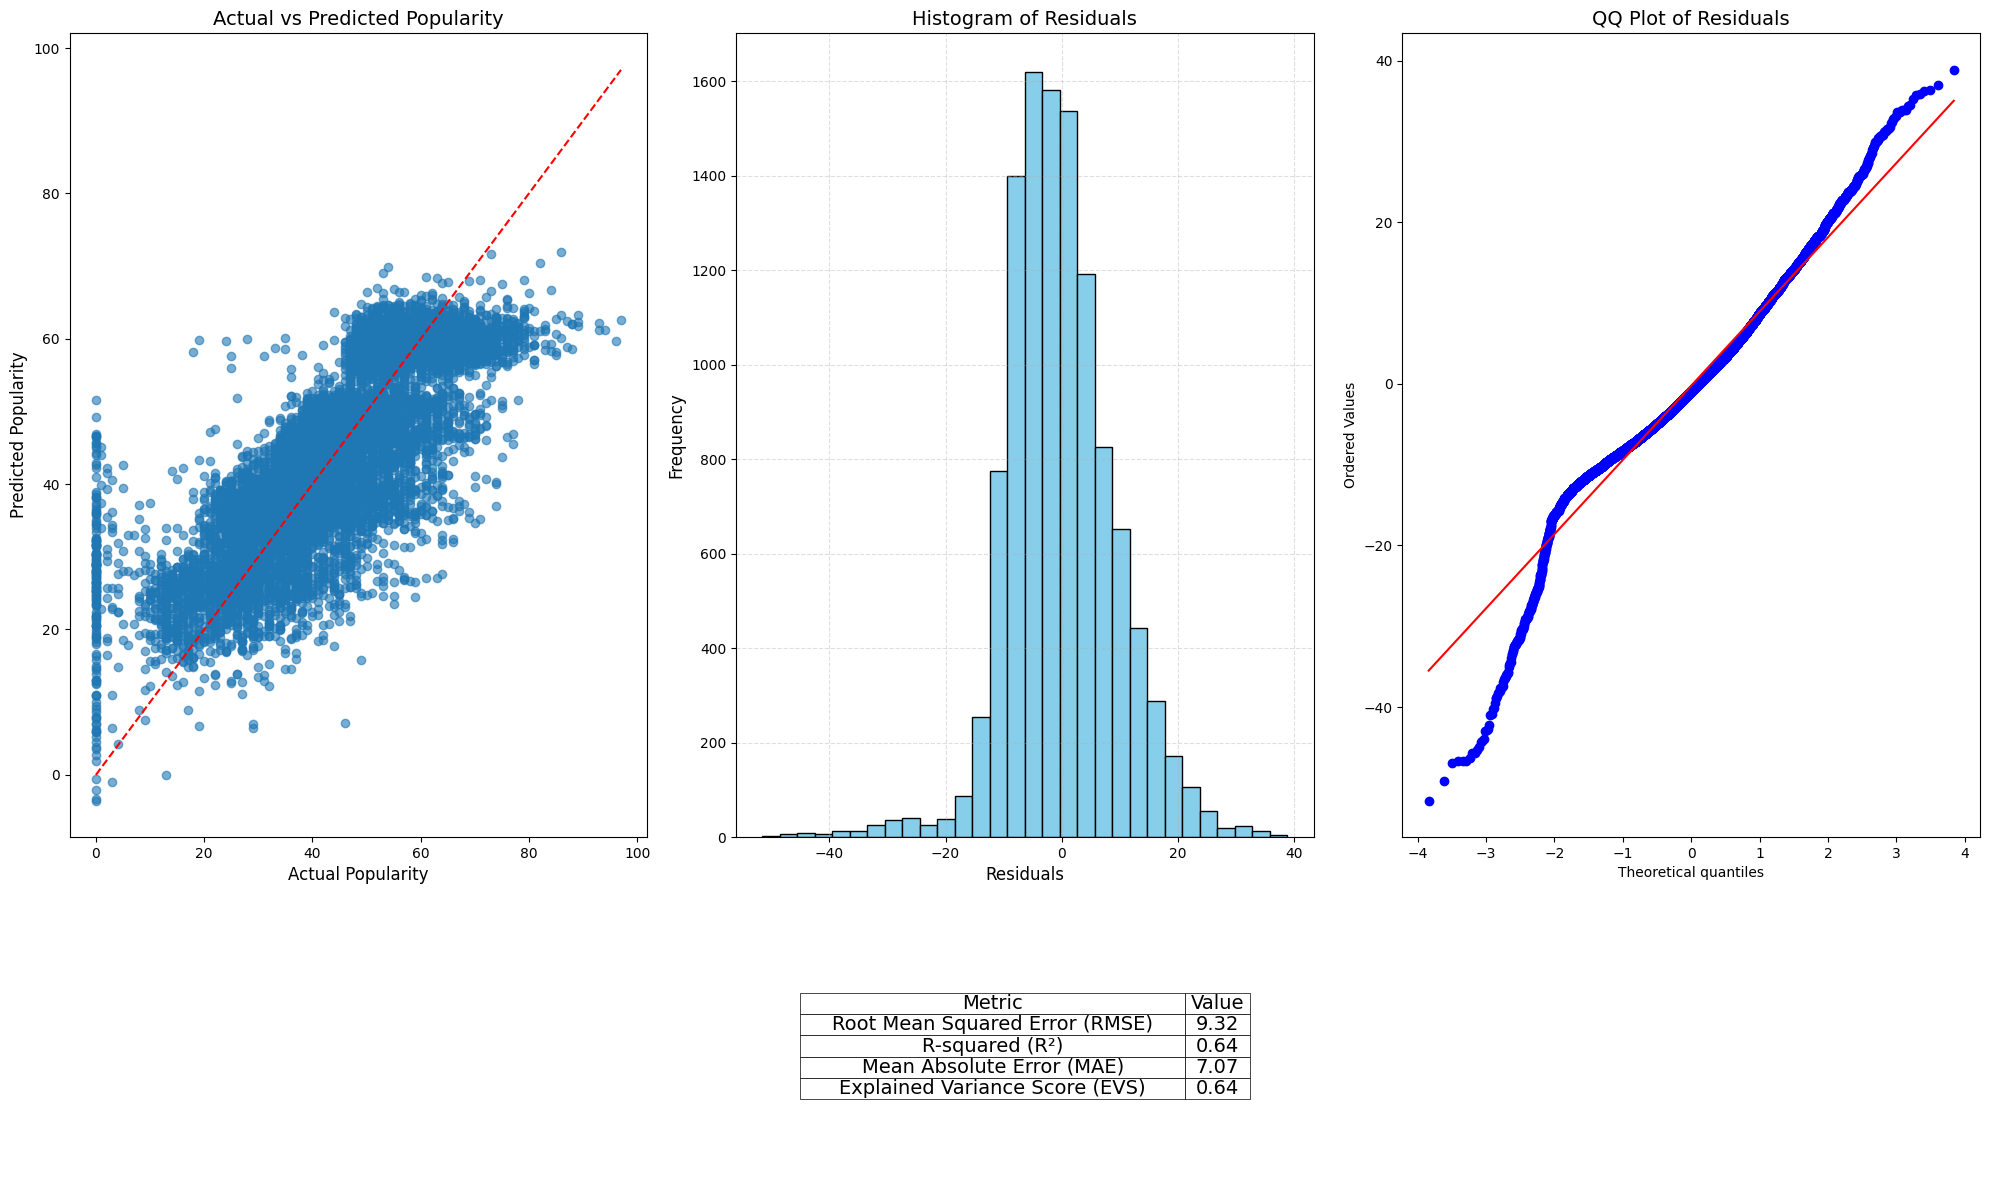

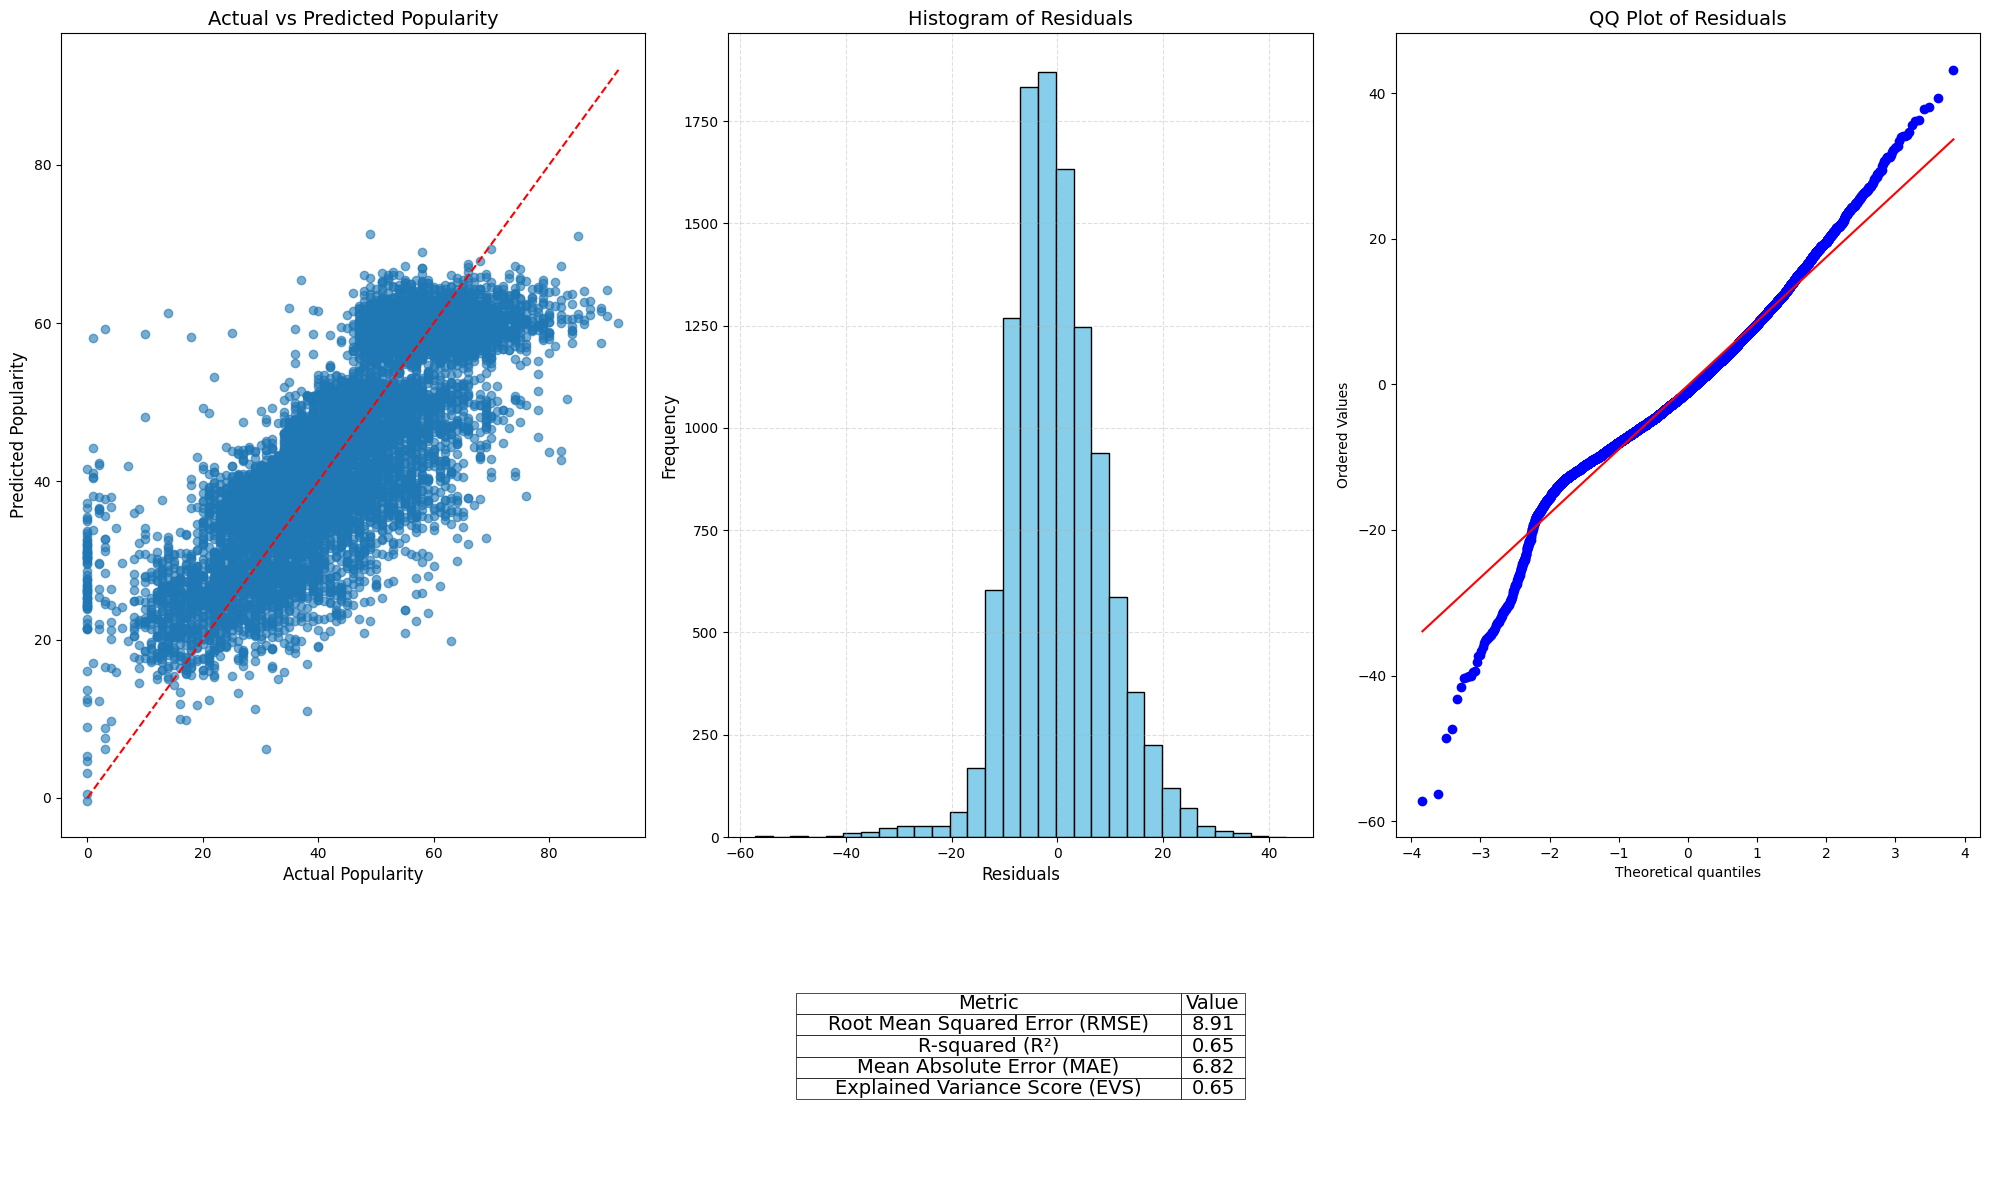

In [234]:
error_analysis(y_test, y_pred)
error_analysis(y_test_new, y_pred_new)

y_test = y_test_new
y_pred = y_pred_new

Handling the missing data and outliers significantly improved the models performance. The RMSE dropped from 9.32 to 8.91, and the MAE improved from 7.07 to 6.82, showing more accurate predictions overall. The residual histogram is now more symmetrical around zero, and the QQ plot shows better alignment with the normal distribution. Overall from the plots we can see better performance in the exteames, with smaller cluster around 0 popularity

### Feature engineering

For the feature engineering process, I experimented with adding and removing various features, achieving the best performance with the current configuration:

In [235]:
raw_data['acoustic_driven'] = raw_data['acousticness'] * (raw_data['instrumentalness'] + raw_data['liveness'])
raw_data['danceability_tempo'] = raw_data['danceability'] * raw_data['tempo']
raw_data['log_loudness'] = np.log(-raw_data['loudness'] + 1)
raw_data['acoustic_energy'] = raw_data['acousticness'] * raw_data['energy']
raw_data['genre_target_encoded'] = raw_data['music_genre'].map(raw_data.groupby('music_genre')['popularity'].mean())


C:\Users\Karma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [236]:
X = raw_data.drop('popularity', axis=1)
y = raw_data['popularity']

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['float64', 'int64']).columns

X_train, X_test, y_train, y_test_new = train_test_split(X, y, test_size=0.25, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

model = XGBRegressor(n_estimators=100, learning_rate=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


pipeline.fit(X_train, y_train)

y_pred_new = pipeline.predict(X_test)

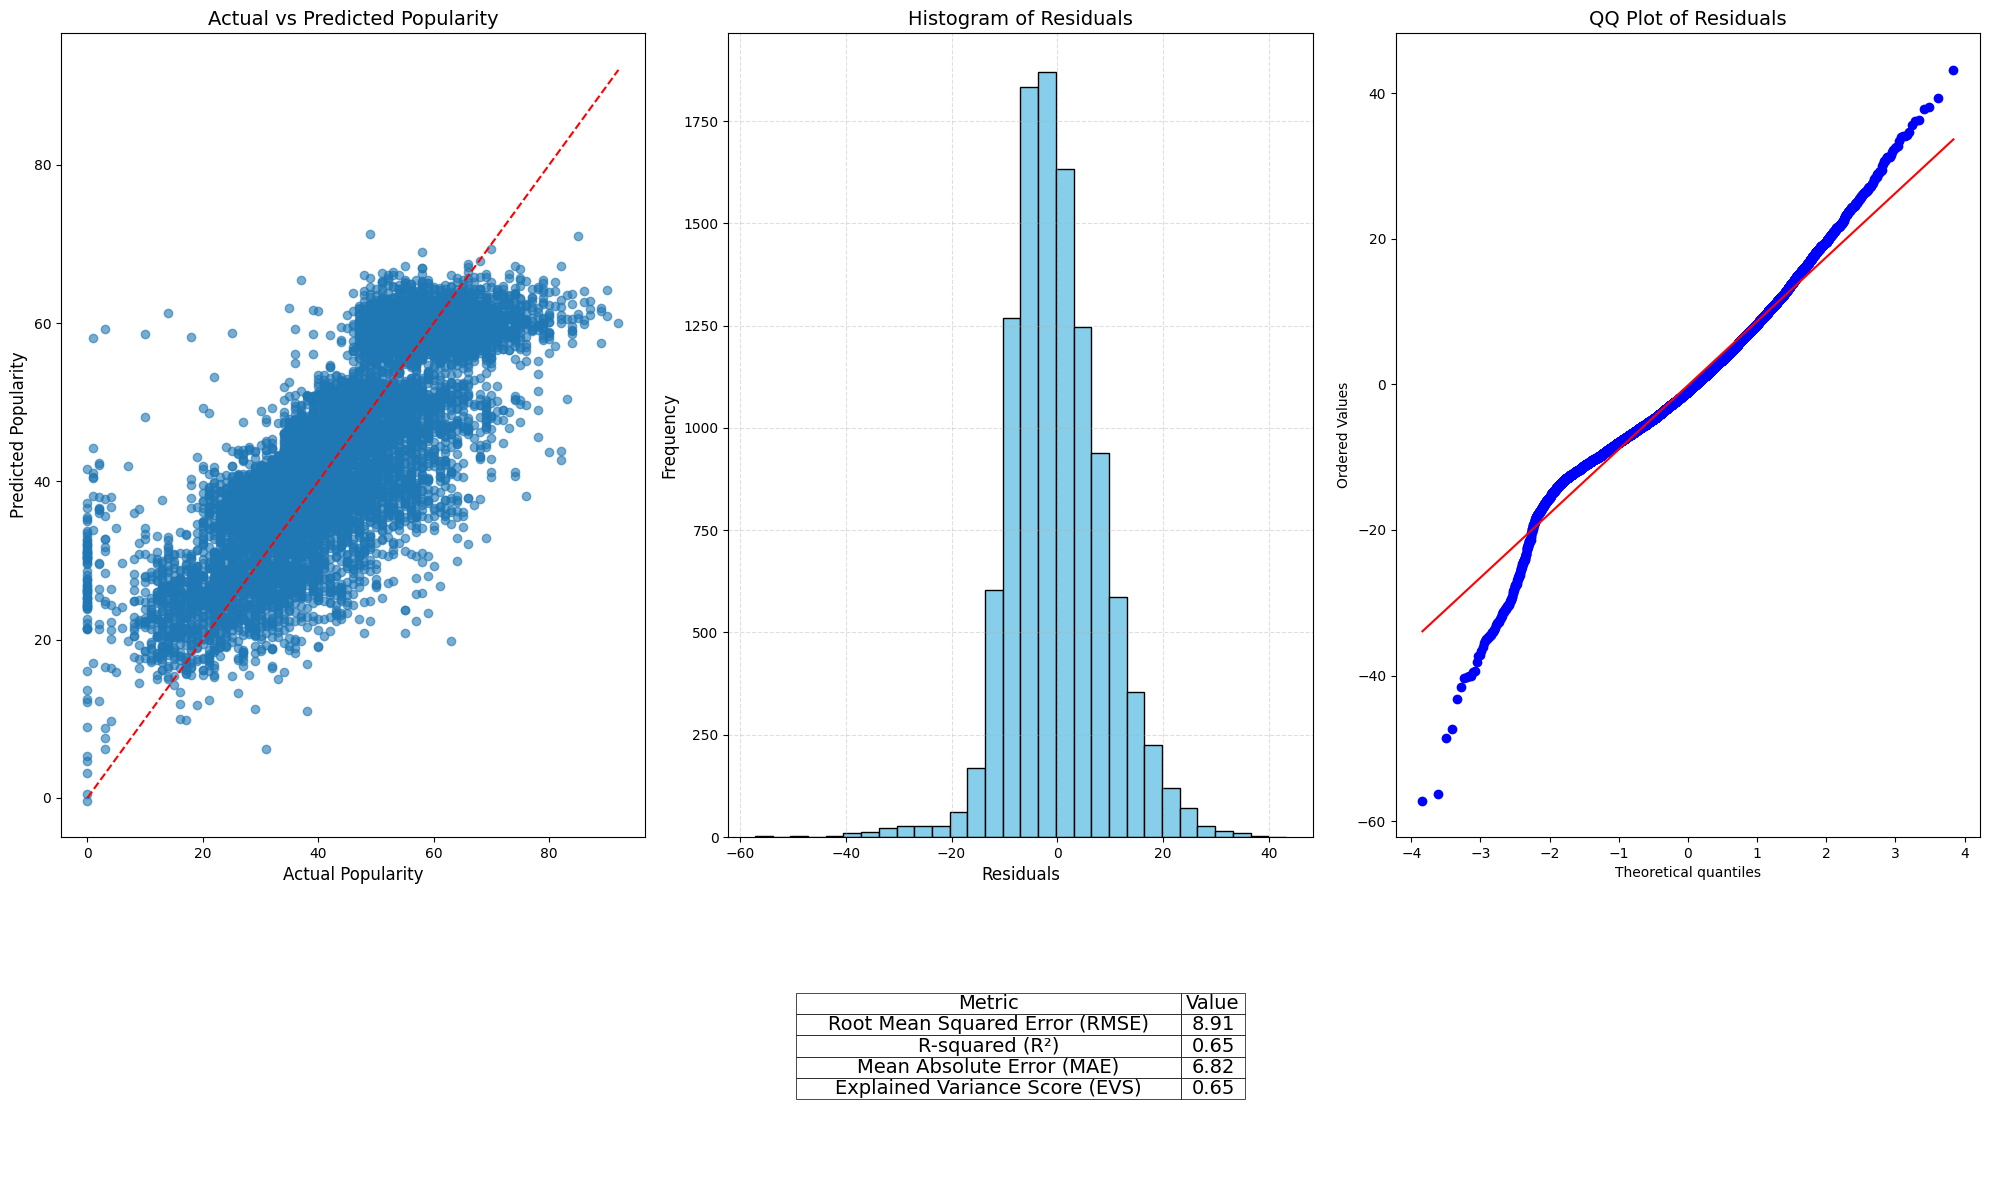

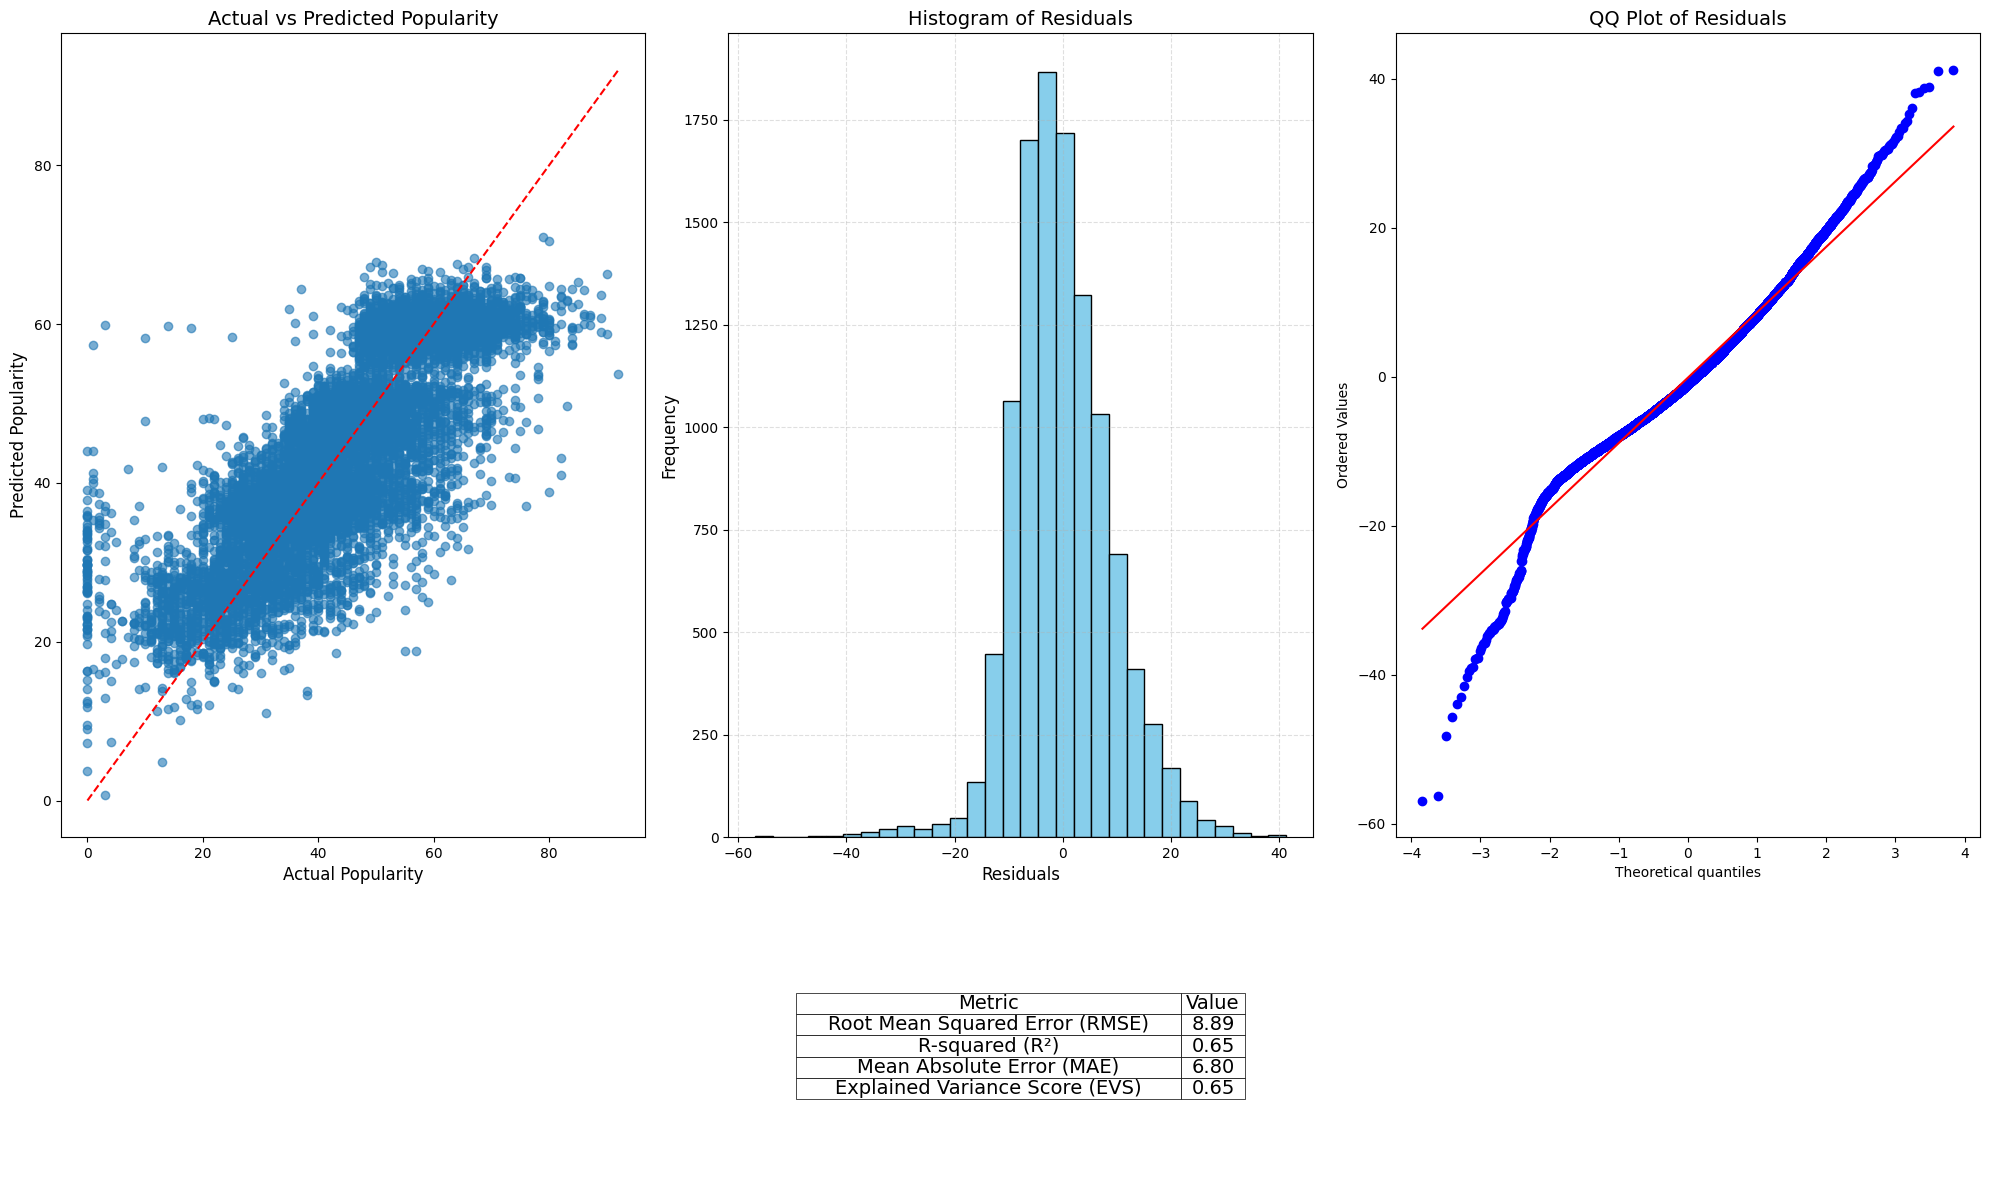

In [237]:
error_analysis(y_test, y_pred)
error_analysis(y_test_new, y_pred_new)

y_test = y_test_new
y_pred = y_pred_new

Feature engineering did not have a significant impact on the models performance. The plots show no noticeable differences, but a slight decrease in RMSE and MAE metrics shows an overall improvement of the model

### Hyperparameter tuning

During the hyperparameter tuning process, I explored multiple hyperparameters and identified the configuration that led the best performance

In [238]:
X_train, X_test, y_train, y_test_new = train_test_split(X, y, test_size=0.1, random_state=42)

model = XGBRegressor(
    n_estimators=950,
    learning_rate=0.02,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


pipeline.fit(X_train, y_train)

y_pred_new = pipeline.predict(X_test)

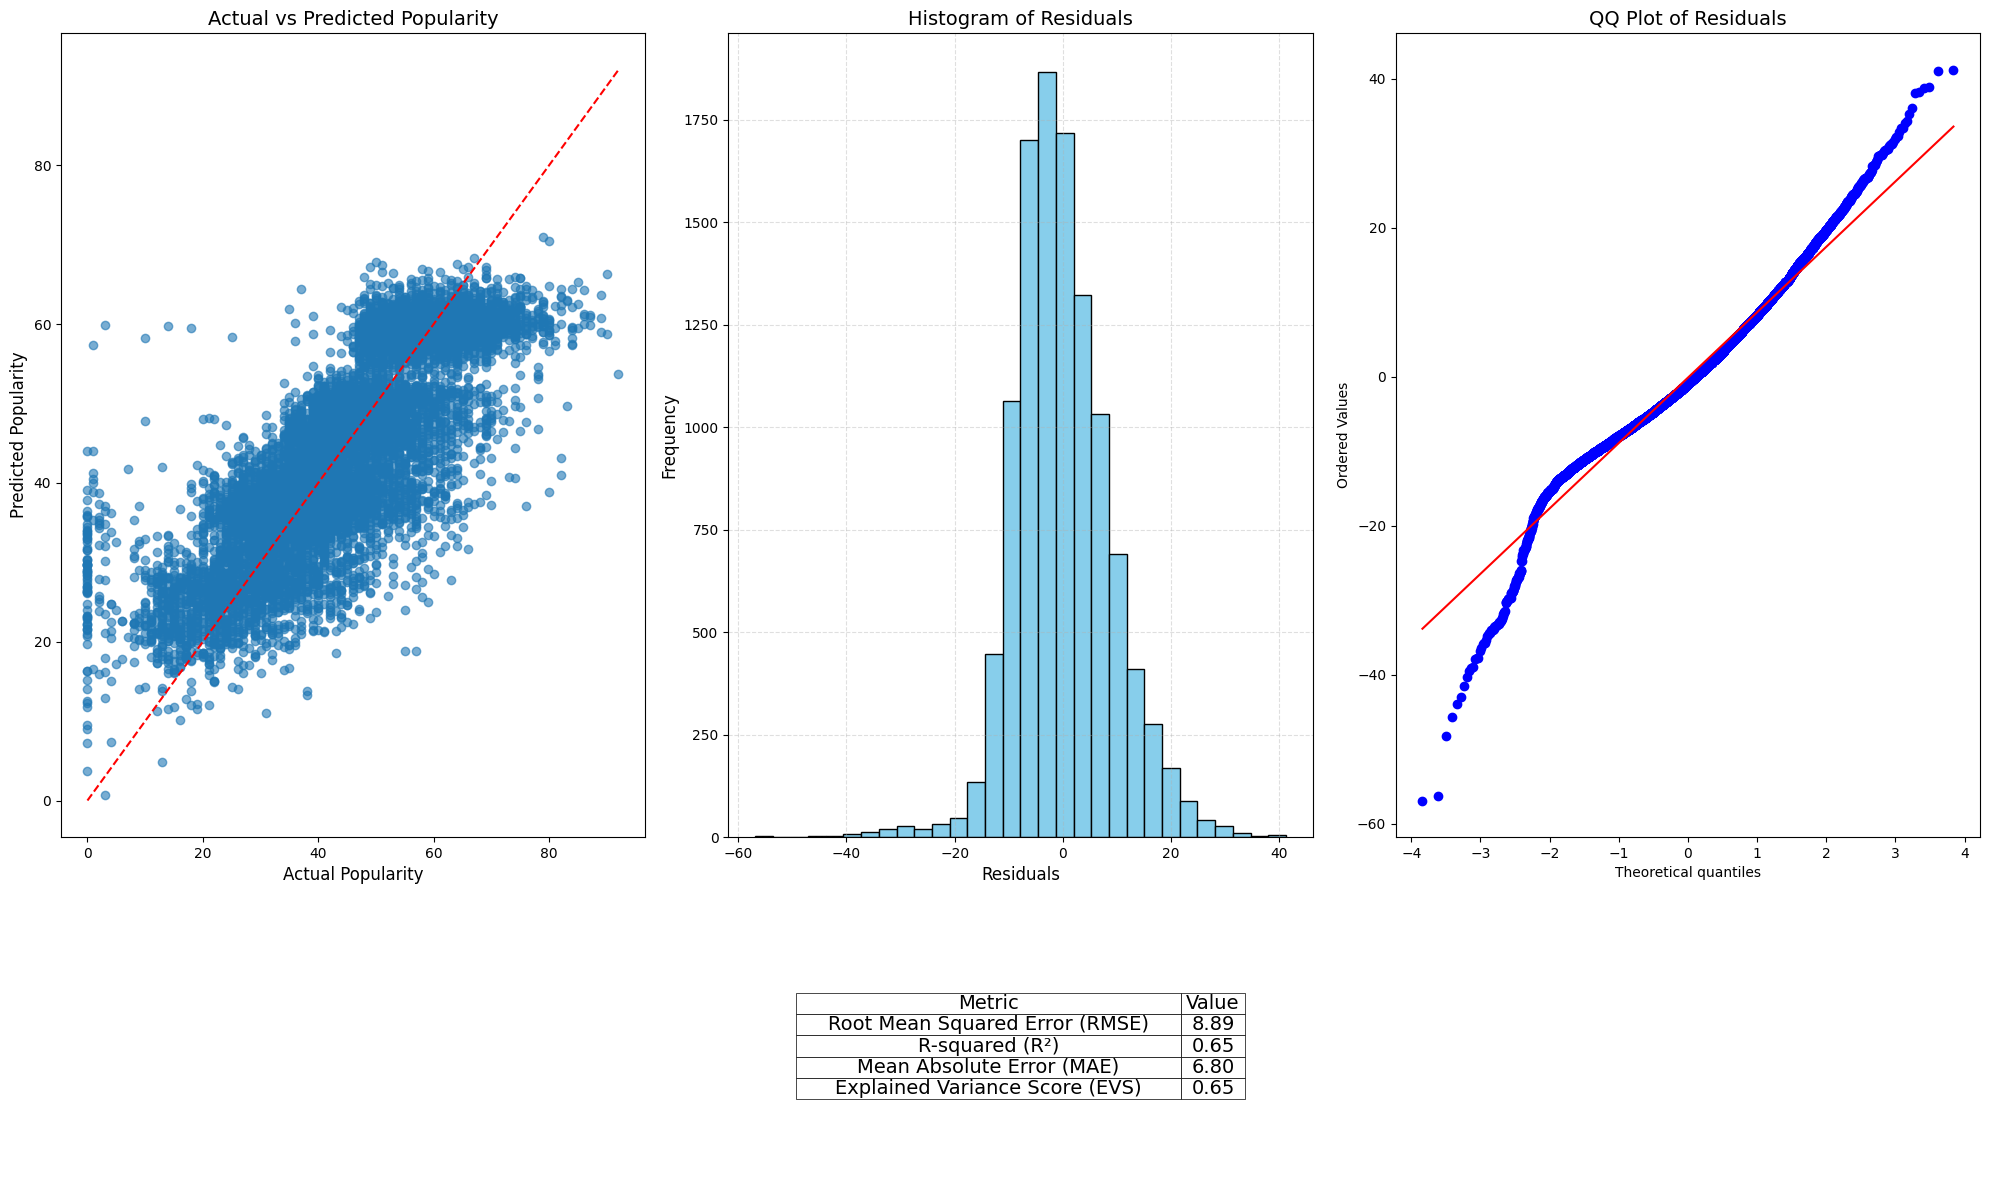

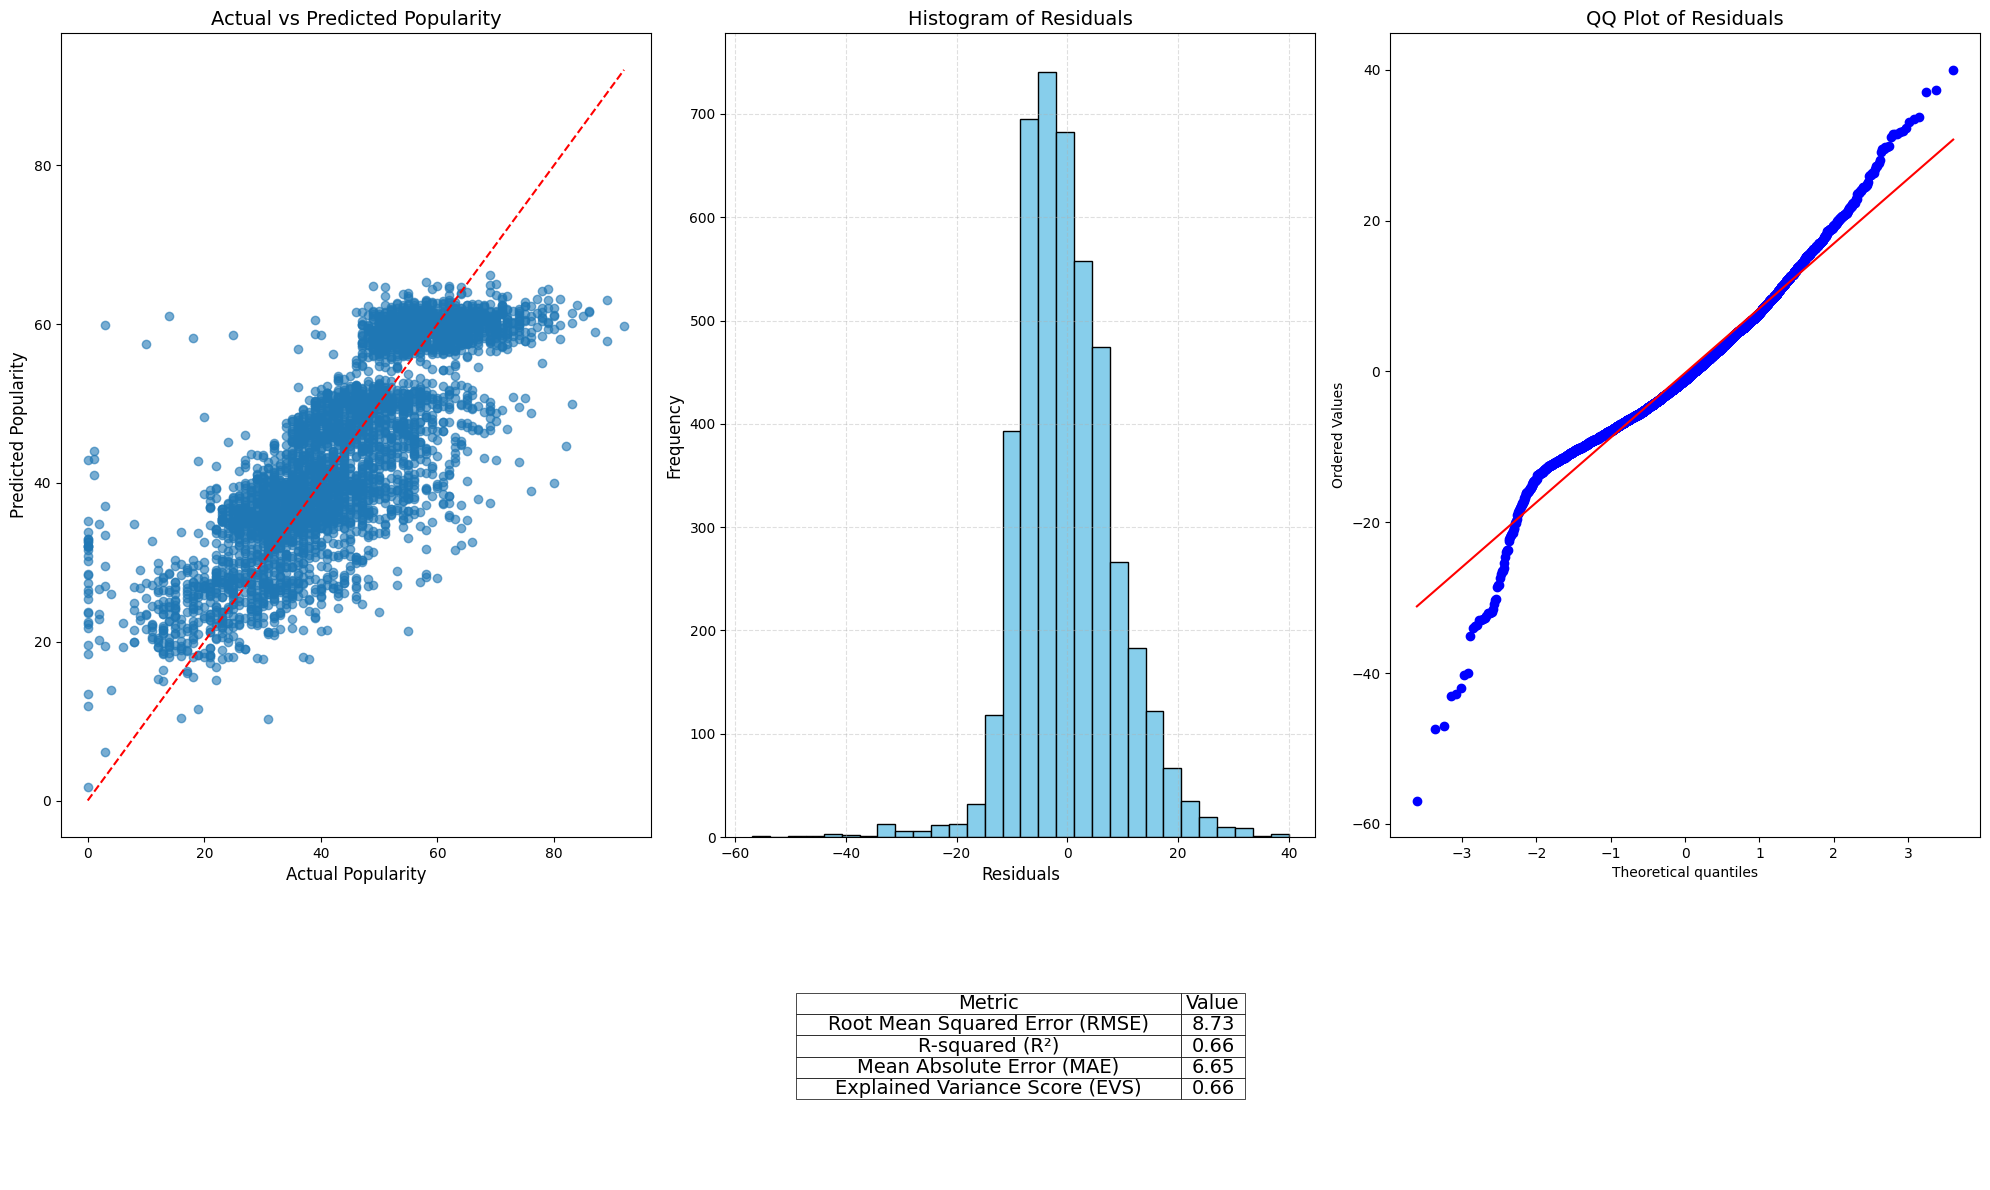

In [239]:
error_analysis(y_test, y_pred)
error_analysis(y_test_new, y_pred_new)

y_test = y_test_new
y_pred = y_pred_new

residuals_impoved = y_test - y_pred

The hyperparameter tuning improvmet is evident in the metrics: RMSE and MAE decreased, indicating reduced prediction error, while R-squared and EVS increased, reflecting better model fit and variance explanation. Additionally, the QQ plot shows a small enhancement in the lower tail, bringing it closer to a normal distribution

## Analyzing the Improved Model

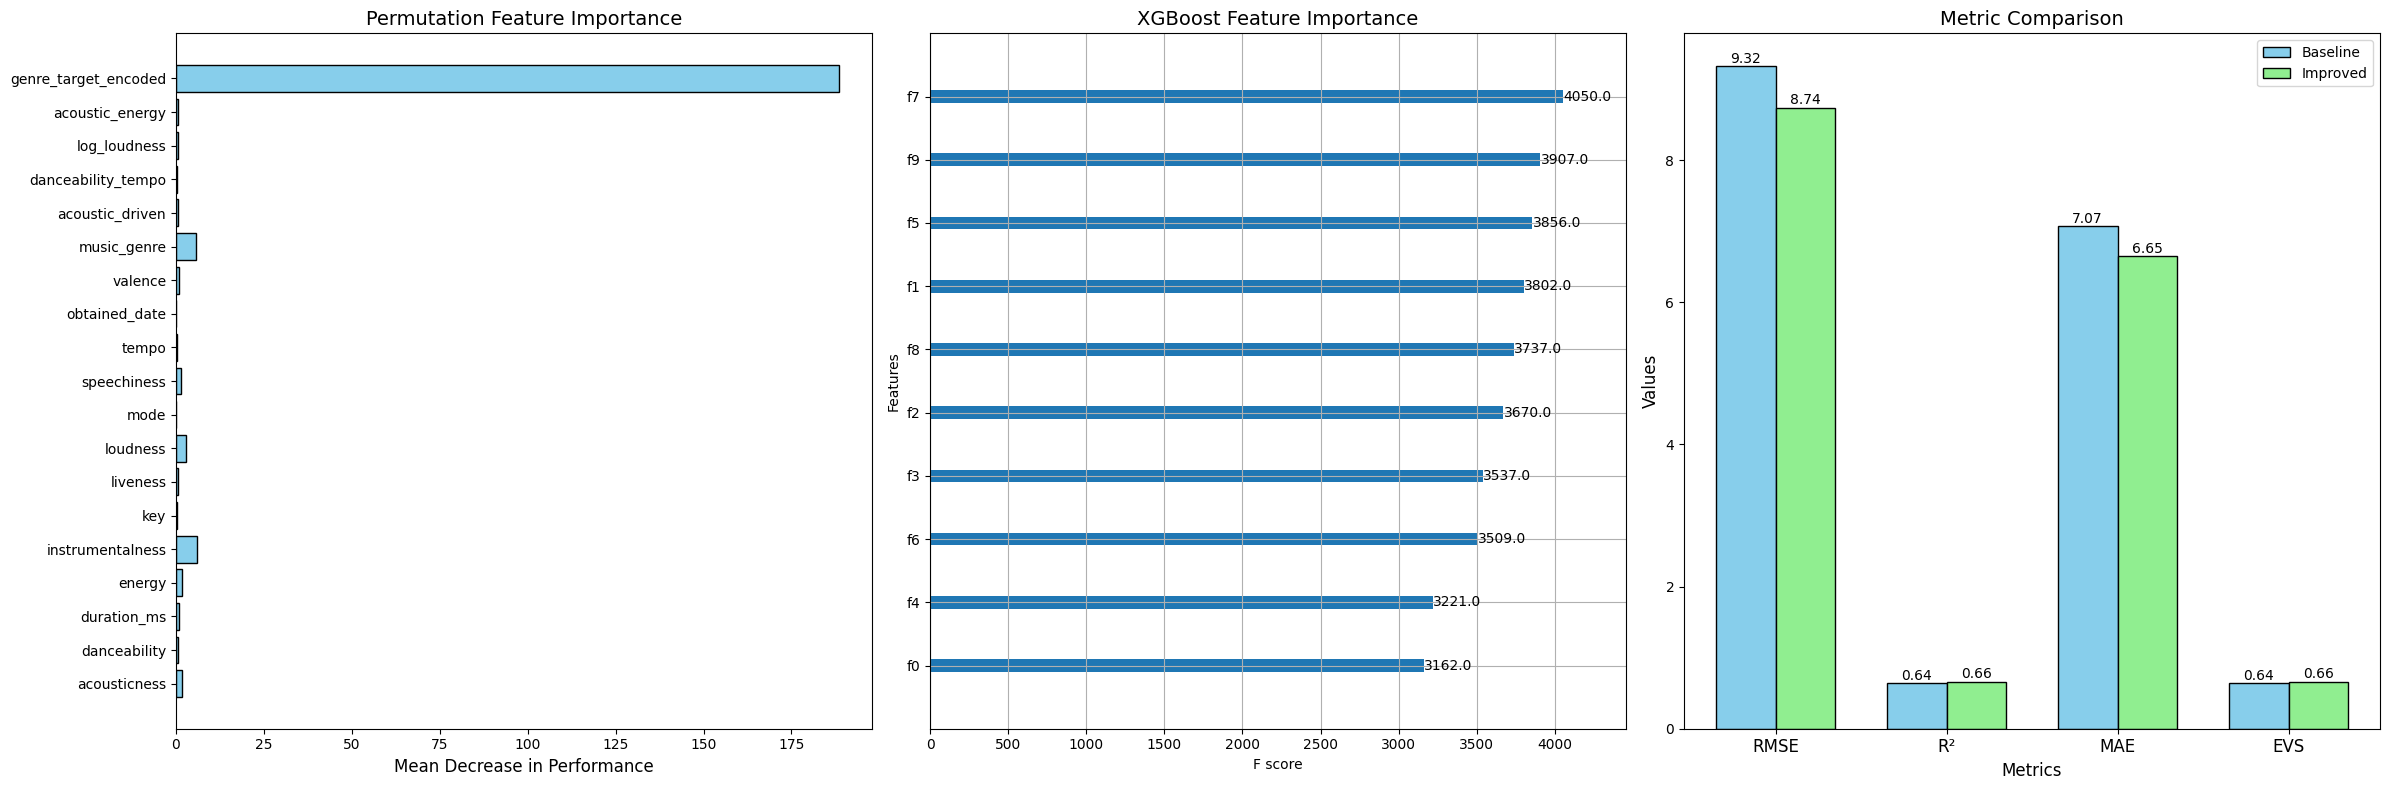

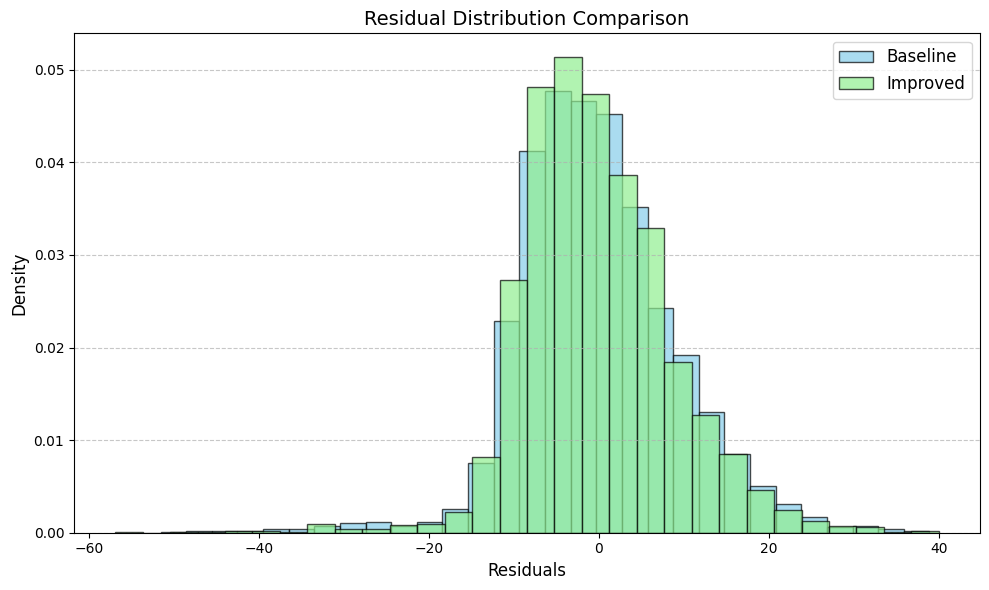

In [240]:

def plot_combined_layout(pipeline, X_test, y_test, baseline_values, improved_values, baseline_residuals, improved_residuals):

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    results = permutation_importance(pipeline, X_test, y_test, scoring='neg_mean_squared_error')
    importance = results.importances_mean
    features = X_test.columns
    axes[0].barh(features, importance, color='skyblue', edgecolor='black')
    axes[0].set_xlabel("Mean Decrease in Performance", fontsize=12)
    axes[0].set_title("Permutation Feature Importance", fontsize=14)

    xgb_model = pipeline.named_steps['regressor']
    ax_xgb = xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10, show_values=True, ax=axes[1])
    axes[1].set_title("XGBoost Feature Importance", fontsize=14)

    metrics = ['RMSE', 'R²', 'MAE', 'EVS']
    x = np.arange(len(metrics))
    width = 0.35
    axes[2].bar(x - width / 2, baseline_values, width, label='Baseline', color='skyblue', edgecolor='black')
    axes[2].bar(x + width / 2, improved_values, width, label='Improved', color='lightgreen', edgecolor='black')
    for i in range(len(metrics)):
        axes[2].text(x[i] - width / 2, baseline_values[i] + 0.05, f"{baseline_values[i]:.2f}", ha='center', fontsize=10)
        axes[2].text(x[i] + width / 2, improved_values[i] + 0.05, f"{improved_values[i]:.2f}", ha='center', fontsize=10)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(metrics, fontsize=12)
    axes[2].set_xlabel("Metrics", fontsize=12)
    axes[2].set_ylabel("Values", fontsize=12)
    axes[2].legend(fontsize=10)
    axes[2].set_title("Metric Comparison", fontsize=14)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(baseline_residuals, bins=30, alpha=0.7, label="Baseline", color='skyblue', edgecolor='black', density=True)
    plt.hist(improved_residuals, bins=30, alpha=0.7, label="Improved", color='lightgreen', edgecolor='black', density=True)
    plt.xlabel("Residuals", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Residual Distribution Comparison", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_combined_layout(
    pipeline=pipeline,
    X_test=X_test,
    y_test=y_test_new,
    baseline_values=[9.32, 0.64, 7.07, 0.64],
    improved_values=[8.74, 0.66, 6.65, 0.66],
    baseline_residuals= base_residuals,
    improved_residuals=residuals_impoved
)


The improved model demonstrates superior performance compared to the baseline. The RMSE decreased from 9.32 to 8.74, indicating a better fit to the data with lower prediction errors. The R-squared value increased from 0.64 to 0.66, highlighting that the improved model explains more variance in the target variable. Similarly, the Mean Absolute Error (MAE) reduced from 7.07 to 6.65, showing that the model makes smaller errors on average. The Explained Variance Score (EVS) also improved from 0.64 to 0.66, confirming that the enhanced model better captures variability in the data. These improvements came from effective preprocessing, including eficent outlier cleaning and missing data hendeling, feature engineering, and parameter tuning.

## 4. Drawing Conclusions About the Data & Creative Applications


The analysis reveals that Music Genre (encodad and not encoded) is the most influential feature in predicting outcomes, as shown by its high permutation importance, while features like loudness, instrumentalness, and energy also contribute meaningfully, but segnifecantly less. Interestingly, XGBoost feature importance suggests that all features hold relatively equal weights, This indicate that the model leverages a variety of features, avoiding over-reliance on any single one. The plots highlight the role of rhythm and energy-related features in determining relevance or success, while liveness, key, and speechiness appear to play minimal roles. The unexpected dominance of music genre could reflect its ability to capture audience preferences or trends, while the significance of instrumentalness suggests opportunities in tracks with little to no vocals.


The improved model reveals that music genre, loudness, and energy significantly influence predictions. This aligns with what we expect in industries like music streaming, where users tend to favor rhythmic, upbeat songs within specific genres that they like. Interestingly, instrumentalness plays a bigger role than initially anticipated, possibly hinting at growing demand for instrumental tracks or background music.

Example for a potential application is that streaming platforms could create more personalized recommendations by factoring in preferences like genre, energy, and loudness. Record labels could use this data to fine-tune their marketing strategies, aligning campaigns with the popularity of certain genres or upbeat music trends to better engage audiences

There's also potential in niche markets, features like instrumentalness suggest opportunities for creating content like cinematic scores or relaxation playlists. Predictive tools could help optimize playlists or evaluate content, giving creators a better chance to connect with listeners and succeed in the market

AI-assisted songwriting, that is rising in our time, could take these findings even further, suggesting song elements that resonate more with audiences

On a broader scale, these insights could even help businesses track cultural shifts by analyzing the rise and fall of different genres and songs